- in our original agenda this week we try different covariance estimation method
- but I think we'd better go directly to regression model
- then we can save some time for further more complicate machine learning models


- this week we focus on the most simple linear regression without regularization

In [1]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
import  sklearn.preprocessing
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM 

16

- number of cores, set this number according to your computer

In [3]:
import warnings
 
warnings.filterwarnings('ignore')

- sample period

In [4]:
period = 4096
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

- get all of the days

In [5]:
import dask
from dask import compute, delayed

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1066

1066

In [15]:
SAVE_PATH = "e:/intern"
split_date = "201910"
train_sample = all_dates<split_date
test_sample = all_dates>split_date
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [16]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [17]:
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])

array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'range.pos.4096', 'price.osci.4096', 'ma.dif.10.4096',
       'kdj.k.4096', 'kdj.j.4096', 'trade.imb.range.4096',
       'total.trade.imb.range.4096', 'nr.range.4096', 'dbook.range.4096',
       'range.pos.range.4096', 'price.osci.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'trade.imb.std.4096', 'total.trade.imb.std.4096', 'nr.std.4096',
       'dbook.std.4096', 'range.pos.std.4096', 'price.osci.std.4096',
       'ma.dif.10.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'trade.imb.volume.open.ratio.4096',
       'total.trade.imb.volume.open.ratio.4096',
       'nr.volume.open.ratio.4096', 'dbook.volume.open.ratio.4096',
       'range.pos.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096',
       'ma.dif.10.volume.open.ratio.4096', 'kdj.k.volume.open.ratio.4096',
       'kdj.j.volume.open.ratio.4096', 'trade.imb.trend.index.4096',
      

In [18]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[9])

- let's begin with week 7 

- to build up a regression model, we need predictors and response variables
- the previous signals can be predictors
- now we need to create a response

- for example, we can use future log returns as response

- here fcum means the future sum of data
- for example

In [19]:
sample_y = fcum(data["ret"], period)

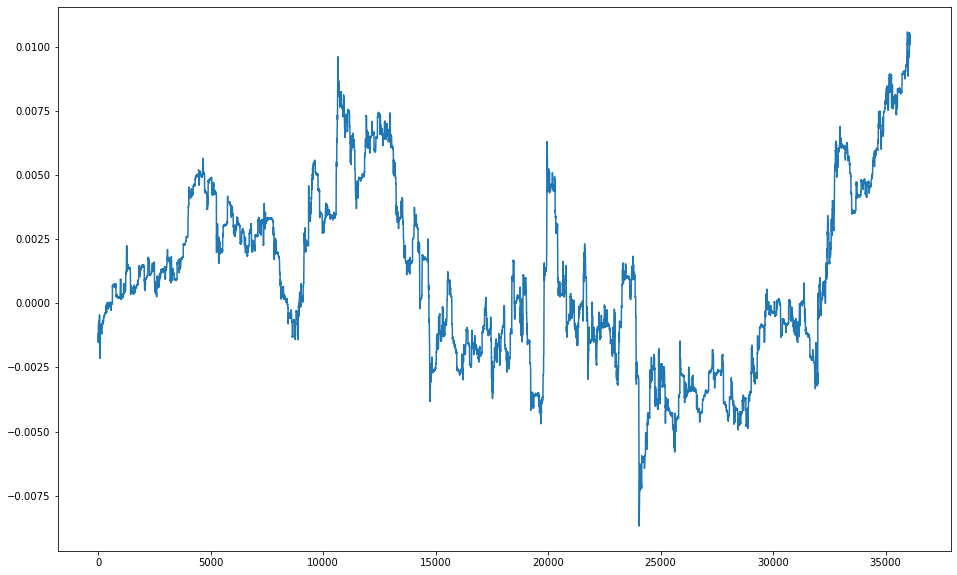

In [20]:
plt.figure(1, figsize=(16, 10))
plt.plot(sample_y[data["good"]].values);

In [21]:
kurtosis(sample_y[data["good"]], fisher=False)
## 2.4167595235045645

2.4167595235045645

- the response has quite high kurtosis, it means the response has fat tails


- we can check the result

In [22]:
np.sum(data["ret"][3000:(3000+period)])
## 0.0029664353958853643

0.0029664353958853643

In [23]:
sample_y[2999]
## 0.0029664353958853635

0.0029664353958853635

- so fcum means future sume, and ys is the future price return

- now we create directory for this response signal

In [24]:
## calculate future return
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y = foctor_ret_period()



In [25]:
for product in product_list:
    create_signal_path(y, product,SAVE_PATH);

e:/intern/tmp pkl/bu/ret.4096
e:/intern/tmp pkl/ru/ret.4096
e:/intern/tmp pkl/v/ret.4096
e:/intern/tmp pkl/pp/ret.4096
e:/intern/tmp pkl/l/ret.4096
e:/intern/tmp pkl/jd/ret.4096


In [26]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 6min 57s



Wall time: 6min 57s


''

- now let's see how it looks like

In [27]:
SAVE_PATH = "e:/intern"

In [28]:
%%time
for product in product_list:
    parLapply(CORE_NUM, ["ret.4096"], par_get_all_signal, file_list=all_dates, product=product, period=4096, SAVE_PATH = SAVE_PATH);

# Wall time: 3min 11s

Wall time: 3min 11s


In [29]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")

- plot the signal

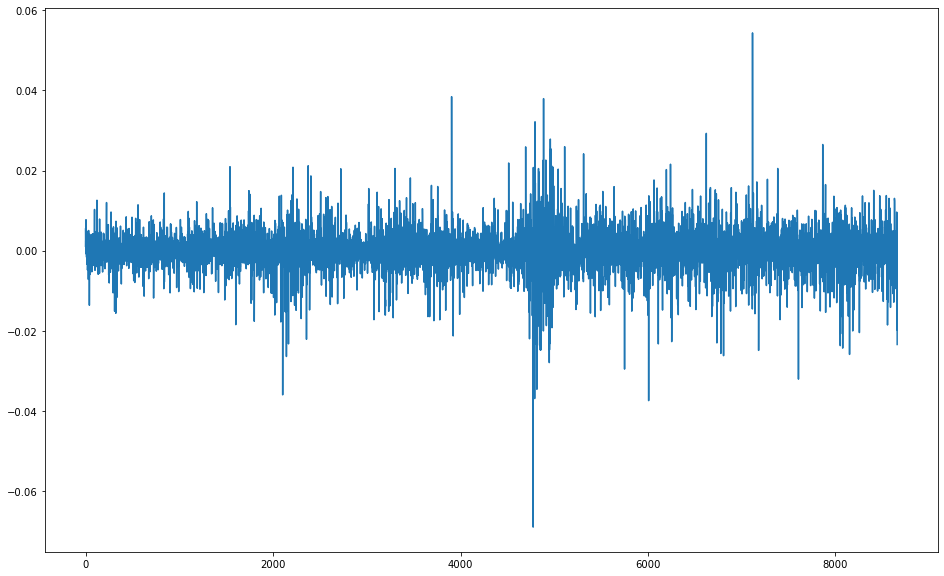

In [30]:
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);

- check the statistics of the signal

In [31]:
print("kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))
## kurtosis= 15.20132738777957  skew= -0.49871076071334847

## we can see it has very fat tails
## usually we don't adjust for response because we want to profit from the fat tails

kurtosis= 15.20132738777957  skew= -0.49871076071334847


- let's try some vanish signal

kurtosis= 10.042842937414168  skew= -0.3627842004677021


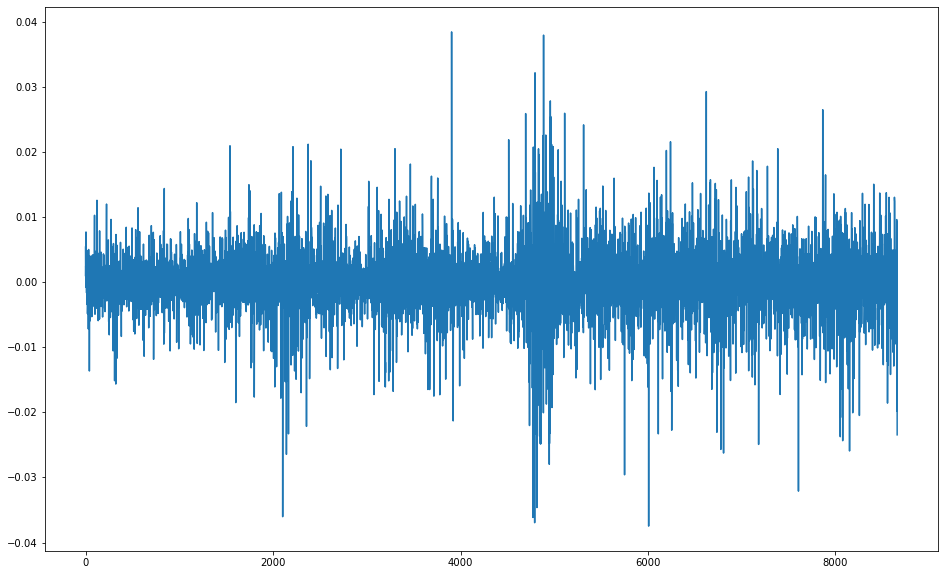

In [32]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.041)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
## kurtosis= 10.042842937414168  skew= -0.3627842004677021

plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);

kurtosis= 5.653946862916019  skew= -0.060498921311801575


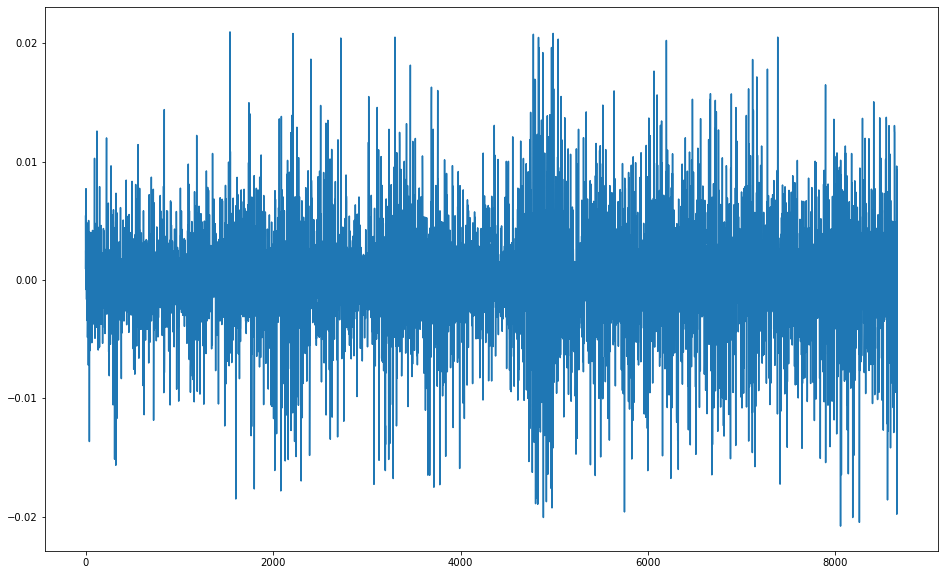

In [33]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.021)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 5.653946862916019  skew= -0.060498921311801575

kurtosis= 3.601558948948569  skew= -0.015095188599431958


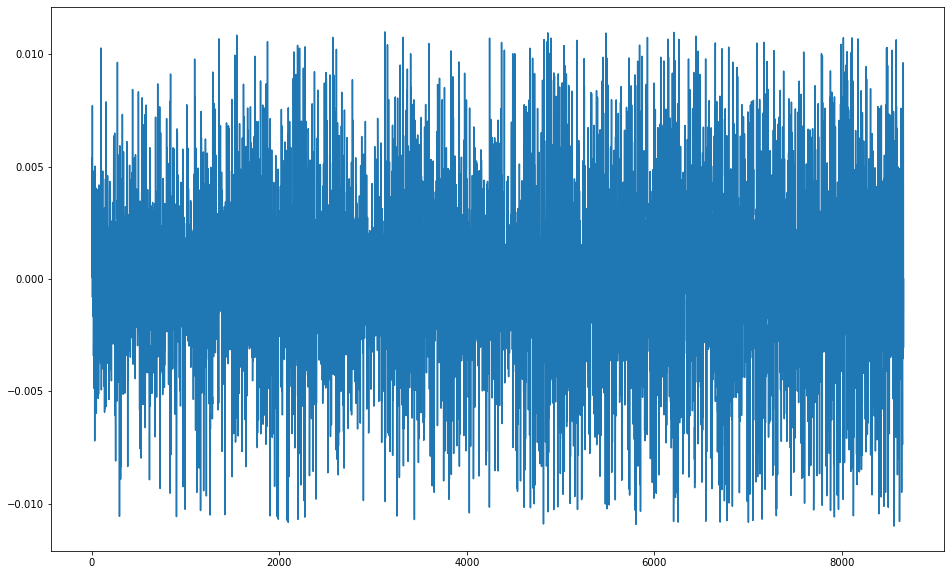

In [34]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.011)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 3.601558948948569  skew= -0.015095188599431958




- it seems 0.01 fits our previous standard for predictive signals
- but now we works for response so there may be some differences


- let's create signals with vanish as well
- our function can support only one parameter so we create twice

In [35]:
class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
    
y4 = foctor_ret_period_004()



In [36]:
class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = foctor_ret_period_002()



In [37]:
for product in product_list:
    create_signal_path(y4, product, SAVE_PATH)

e:/intern/tmp pkl/bu/ret.4096.004
e:/intern/tmp pkl/ru/ret.4096.004
e:/intern/tmp pkl/v/ret.4096.004
e:/intern/tmp pkl/pp/ret.4096.004
e:/intern/tmp pkl/l/ret.4096.004
e:/intern/tmp pkl/jd/ret.4096.004


In [38]:
for product in product_list:
    create_signal_path(y2, product, SAVE_PATH)

e:/intern/tmp pkl/bu/ret.4096.002
e:/intern/tmp pkl/ru/ret.4096.002
e:/intern/tmp pkl/v/ret.4096.002
e:/intern/tmp pkl/pp/ret.4096.002
e:/intern/tmp pkl/l/ret.4096.002
e:/intern/tmp pkl/jd/ret.4096.002


In [39]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y4, product=product, HEAD_PATH=SAVE_PATH)
;
## Wall time: 3min 58s

Wall time: 3min 58s


''

In [40]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y2, product=product, HEAD_PATH=SAVE_PATH)
;
## Wall time: 3min 52s

Wall time: 3min 52s


''

In [41]:
class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y1 = foctor_ret_period_001()


In [42]:
for product in product_list:
    create_signal_path(y1, product, SAVE_PATH)

e:/intern/tmp pkl/bu/ret.4096.001
e:/intern/tmp pkl/ru/ret.4096.001
e:/intern/tmp pkl/v/ret.4096.001
e:/intern/tmp pkl/pp/ret.4096.001
e:/intern/tmp pkl/l/ret.4096.001
e:/intern/tmp pkl/jd/ret.4096.001


In [43]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y1, product=product, HEAD_PATH=SAVE_PATH)
;
##Wall time: 3min 50s

Wall time: 3min 50s


''

- now we have 3 response values: future return, future return cut off at 0.02, future return cut of at 0.01


- let's see how they perform with predictive signals


- at first we need to make sum changes 
- we can check the result

In [44]:
sum(train_sample)
## 486

486

In [45]:
sum(test_sample)
## 580

580

- at first we fit a linear regression model without any regularization
- we need to know the length of each day

In [46]:
## coutn the number of signals of every day
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [47]:
os.makedirs(HEAD_PATH+"/daily num", exist_ok=True)

In [48]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")
    
# Wall time: 2min 39s

Wall time: 2min 39s


- we don't need to do it every time

In [49]:
daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")

- we get the number of independent training samples

In [50]:
n_train = sum(daily_num[train_sample])
n_train
## 1563.0

1563.0

- we can see there there are not many samples
- but they are independent signals because we choose one sample out of every period samples
- for every tick, we predict the price return of next 4096 ticks
- so only 1/4096 of them are independent

- number of signals

In [51]:
n_signal = len(signal_list)
n_signal
## 45

45

In [52]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_days = sum(sample)  ## number of days
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        #data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        good = load(SAVE_PATH + "/good pkl/" + product +"/"+file)
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

- Now we get the train and test samples

In [53]:
os.makedirs(HEAD_PATH+"/train test mat/", exist_ok=True)

In [54]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    train_mat = get_sample_signal(all_dates, train_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004" ]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(train_mat, HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    
# bu
# ru
# v
# pp
# l
# jd
# Wall time: 1h 27min 49s



bu
ru
v
pp
l
jd
Wall time: 1h 27min 49s


In [55]:
import  sklearn.preprocessing

In [56]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
ori_mat.columns

Index(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'range.pos.4096', 'price.osci.4096', 'ma.dif.10.4096', 'kdj.k.4096',
       'kdj.j.4096', 'trade.imb.range.4096', 'total.trade.imb.range.4096',
       'nr.range.4096', 'dbook.range.4096', 'range.pos.range.4096',
       'price.osci.range.4096', 'ma.dif.10.range.4096', 'kdj.k.range.4096',
       'kdj.j.range.4096', 'trade.imb.std.4096', 'total.trade.imb.std.4096',
       'nr.std.4096', 'dbook.std.4096', 'range.pos.std.4096',
       'price.osci.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'trade.imb.volume.open.ratio.4096',
       'total.trade.imb.volume.open.ratio.4096', 'nr.volume.open.ratio.4096',
       'dbook.volume.open.ratio.4096', 'range.pos.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096', 'ma.dif.10.volume.open.ratio.4096',
       'kdj.k.volume.open.ratio.4096', 'kdj.j.volume.open.ratio.4096',
       'trade.imb.trend.index.4096', 'total.trade.imb.tre

- we add the y signal

- we can check the names

In [57]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=True), columns=ori_mat.columns)
print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    ## standardize the matrix before combination, with_mean=False,we don't use intercept
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=True), columns=ori_mat.columns)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
    
# bu (4000, 49)
# ru (4164, 49)
# v (1756, 49)
# pp (2674, 49)
# l (1937, 49)
# jd (1563, 49)



bu (4000, 49)
ru (4164, 49)
v (1756, 49)
pp (2674, 49)
l (1937, 49)
jd (1563, 49)


In [58]:
train_mat.shape

# (16094, 49)

(16094, 49)

- at first we can fit a linear regression to calcualte t-statistics 

In [59]:
import statsmodels.formula.api as smf

In [60]:
formula = "train_mat['ret."+str(period)+"'] ~ train_mat['nr."+str(period)+"'] + 0"
formula
## "train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

"train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

In [61]:
fit_one_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_one_lm.summary())

#                                   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.000
# Model:                               OLS   Adj. R-squared (uncentered):             -0.000
# Method:                    Least Squares   F-statistic:                             0.6149
# Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                       0.433
# Time:                           14:21:24   Log-Likelihood:                         -22836.
# No. Observations:                  16094   AIC:                                  4.567e+04
# Df Residuals:                      16093   BIC:                                  4.568e+04
# Df Model:                              1                                                  
# Covariance Type:               nonrobust                                                  
# ========================================================================================
#                            coef    std err          t      P>|t|      [0.025      0.975]
# ----------------------------------------------------------------------------------------
# train_mat['nr.4096']     0.0062      0.008      0.784      0.433      -0.009       0.022
# ==============================================================================
# Omnibus:                     2323.389   Durbin-Watson:                   2.002
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32951.028
# Skew:                          -0.163   Prob(JB):                         0.00
# Kurtosis:                      10.002   Cond. No.                         1.00
# ==============================================================================

# Notes:
# [1] R² is computed without centering (uncentered) since the model does not contain a constant.
# [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.000
Model:                               OLS   Adj. R-squared (uncentered):             -0.000
Method:                    Least Squares   F-statistic:                             0.6149
Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                       0.433
Time:                           14:21:24   Log-Likelihood:                         -22836.
No. Observations:                  16094   AIC:                                  4.567e+04
Df Residuals:                      16093   BIC:                                  4.568e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-

In [62]:
## function to calculate t-stat
def get_t_value(train_mat, signal, response):
    beta = np.sum(train_mat[signal]*train_mat[response])/sum(train_mat[signal]**2) ## regressio coef
    sigma = np.sqrt(np.sum((train_mat[signal]*beta-train_mat[response])**2) / (len(train_mat)-1)) 
    v = np.sqrt(np.sum(train_mat[signal]**2)) ## sigma/v is the standard devication of beta_hat
    return beta/sigma*v

- we can see our function is correct
- now let's use this function to calcualte all t-stat of each variable

In [63]:
signal_list = np.array(signal_list)
t_stat = list(map(lambda x: get_t_value(train_mat=train_mat, signal=x, response="ret."+str(period)), signal_list))
t_stat

# [-2.030148128851061,
#  0.08074798613005739,
#  0.7841661053857313,
#  -2.8888624454923435,
#  -0.5588440966632381,
#  1.469067305518296,
#  0.2183556225995931,
#  -0.21678986343730133,
#  -0.6058584191371985,
#  -1.608222557795836,
#  -0.37016666063999454,
#  -0.28714554094972083,
#  -3.2824033219748037,
#  -1.4347317009666272,
#  0.2942254713735205,
#  -0.5895334957572106,
#  -0.33627908143256224,
#  -0.9219302090149365,
#  -1.5356006773767248,
#  -0.4990505601568903,
#  -0.37528033773860203,
#  -3.154339810802585,
#  -1.4005546951311396,
#  0.17381962405719148,
#  -0.5481329891577154,
#  -0.2446914163961505,
#  -0.8448582702952505,
#  -1.6091391221421312,
#  -0.23162829658524833,
#  0.22853516835328339,
#  -2.9668796361749967,
#  -1.038864558729745,
#  0.48844420179898695,
#  0.07410503126855984,
#  0.015906634492721724,
#  -0.5418839093062212,
#  -2.241080653037907,
#  0.4126883055327951,
#  0.6117249001882055,
#  -2.6222242641010993,
#  0.2502375206198821,
#  1.4092570888463185,
#  0.5950492793329274,
#  0.222943131674607,
#  0.19413426275049578]

[-2.030148128851061,
 0.08074798613005739,
 0.7841661053857313,
 -2.8888624454923435,
 -0.5588440966632381,
 1.469067305518296,
 0.2183556225995931,
 -0.21678986343730133,
 -0.6058584191371985,
 -1.608222557795836,
 -0.37016666063999454,
 -0.28714554094972083,
 -3.2824033219748037,
 -1.4347317009666272,
 0.2942254713735205,
 -0.5895334957572106,
 -0.33627908143256224,
 -0.9219302090149365,
 -1.5356006773767248,
 -0.4990505601568903,
 -0.37528033773860203,
 -3.154339810802585,
 -1.4005546951311396,
 0.17381962405719148,
 -0.5481329891577154,
 -0.2446914163961505,
 -0.8448582702952505,
 -1.6091391221421312,
 -0.23162829658524833,
 0.22853516835328339,
 -2.9668796361749967,
 -1.038864558729745,
 0.48844420179898695,
 0.07410503126855984,
 0.015906634492721724,
 -0.5418839093062212,
 -2.241080653037907,
 0.4126883055327951,
 0.6117249001882055,
 -2.6222242641010993,
 0.2502375206198821,
 1.4092570888463185,
 0.5950492793329274,
 0.222943131674607,
 0.19413426275049578]

- if we use t.stat value of 2 to filter out good signals, we have

In [64]:
signal_list[np.where(np.abs(t_stat)>2)]

# array(['trade.imb.4096', 'dbook.4096', 'dbook.range.4096',
#        'dbook.std.4096', 'dbook.volume.open.ratio.4096',
#        'trade.imb.trend.index.4096', 'dbook.trend.index.4096'],
#       dtype='<U38')

array(['trade.imb.4096', 'dbook.4096', 'dbook.range.4096',
       'dbook.std.4096', 'dbook.volume.open.ratio.4096',
       'trade.imb.trend.index.4096', 'dbook.trend.index.4096'],
      dtype='<U38')

- but we know a single signal works well doesn't mean it works well when combined with other signals
- signals have correlation, if 10 highly correlated signals together would not make prediction better

In [65]:
good_index = np.where(np.abs(t_stat)>2)
train_mat.iloc[good_index].corr()



,trade.imb.4096,total.trade.imb.4096,nr.4096,dbook.4096,range.pos.4096,price.osci.4096,ma.dif.10.4096,kdj.k.4096,kdj.j.4096,trade.imb.range.4096,...,dbook.trend.index.4096,range.pos.trend.index.4096,price.osci.trend.index.4096,ma.dif.10.trend.index.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096,ret.4096,ret.4096.001,ret.4096.002,ret.4096.004
trade.imb.4096,1.000000,0.325696,-0.173841,0.923962,0.172929,0.096499,-0.361561,0.065787,0.121754,0.697150,...,0.908671,0.093658,0.028064,-0.374282,0.005135,0.053844,0.025316,0.025316,0.025316,0.025316
total.trade.imb.4096,0.325696,1.000000,0.855105,0.023887,0.906415,0.876228,0.653771,0.782443,0.809672,-0.297392,...,-0.012704,0.864639,0.878996,0.629169,0.783081,0.788822,-0.304812,-0.304812,-0.304812,-0.304812
nr.4096,-0.173841,0.855105,1.000000,-0.431253,0.895486,0.910901,0.857294,0.871114,0.869438,-0.686087,...,-0.461006,0.889084,0.946982,0.835274,0.896764,0.876780,-0.362056,-0.362056,-0.362056,-0.362056
dbook.4096,0.923962,0.023887,-0.431253,1.000000,-0.068245,-0.118010,-0.590088,-0.161884,-0.078574,0.832781,...,0.997374,-0.144771,-0.207193,-0.601001,-0.245071,-0.151493,0.221778,0.221778,0.221778,0.221778
range.pos.4096,0.172929,0.906415,0.895486,-0.068245,1.000000,0.881767,0.793204,0.821912,0.959719,-0.517287,...,-0.114827,0.990462,0.906985,0.771849,0.828534,0.964296,-0.487109,-0.487109,-0.487109,-0.487109
price.osci.4096,0.096499,0.876228,0.910901,-0.118010,0.881767,1.000000,0.614321,0.937262,0.908752,-0.379784,...,-0.144753,0.825854,0.991386,0.580033,0.919560,0.869759,-0.253038,-0.253038,-0.253038,-0.253038
ma.dif.10.4096,-0.361561,0.653771,0.857294,-0.590088,0.793204,0.614321,1.000000,0.553211,0.711421,-0.900000,...,-0.635463,0.855769,0.701030,0.999033,0.618512,0.782442,-0.603955,-0.603955,-0.603955,-0.603955
kdj.k.4096,0.065787,0.782443,0.871114,-0.161884,0.821912,0.937262,0.553211,1.000000,0.899291,-0.395095,...,-0.178982,0.769609,0.937653,0.521276,0.993199,0.859300,-0.261477,-0.261477,-0.261477,-0.261477
kdj.j.4096,0.121754,0.809672,0.869438,-0.078574,0.959719,0.908752,0.711421,0.899291,1.000000,-0.503561,...,-0.119952,0.940001,0.927917,0.686026,0.896103,0.991790,-0.492525,-0.492525,-0.492525,-0.492525
trade.imb.range.4096,0.697150,-0.297392,-0.686087,0.832781,-0.517287,-0.379784,-0.900000,-0.395095,-0.503561,1.000000,...,0.862119,-0.606878,-0.483394,-0.907398,-0.475600,-0.592210,0.544229,0.544229,0.544229,0.544229


In [66]:
corr = train_mat.iloc[good_index].corr()

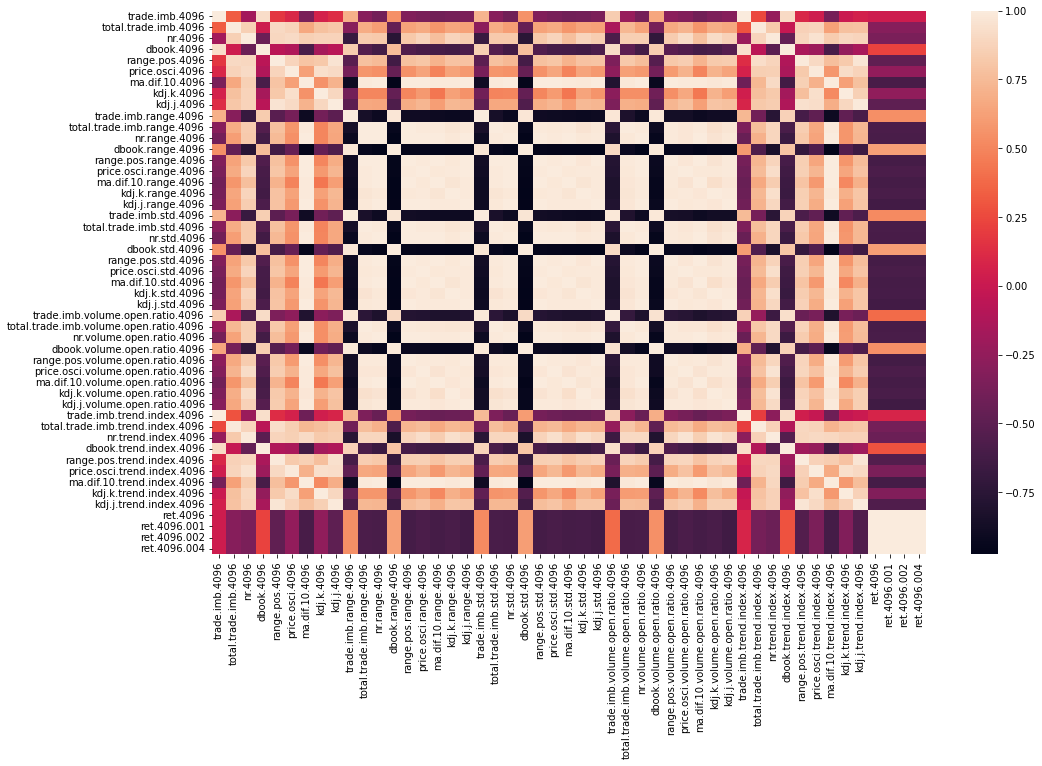

In [67]:
import seaborn as sns
plt.figure(figsize=(16,10)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

- we can see that some of them has very high correlation

- we can add each signal one by one to a model and check how the performance envolves

In [68]:
np.argmax(np.abs(t_stat))
## [1] 12

12

In [69]:
signal_list[np.argmax(np.abs(t_stat))]
## 'dbook.range.4096'

'dbook.range.4096'

- the first signal is the signal dbook.std.4096


- to select the second signal, we can use forward selction

In [70]:
import statsmodels.formula.api as smf

## forward selection of signals
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    chosen_signals = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format("data['"+response+"']",
                                           ' + '.join(selected + ["data['"+candidate+"']"]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append("data['"+best_candidate+"']")
            current_score = best_new_score
            chosen_signals.append(best_candidate)
    formula = "{} ~ {} - 1".format("data['"+response+"']",
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return OrderedDict([("model", model), ("chosen.signals", chosen_signals)])

In [71]:
result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))

In [72]:
save(result, HEAD_PATH+"/energy_all_forwatd_select.pkl")

In [73]:
result = load(HEAD_PATH+"/energy_all_forwatd_select.pkl");

In [74]:
result["model"].model.formula
# "data['ret.4096'] ~ data['dbook.range.4096'] + data['range.pos.range.4096'] + data['ma.dif.10.trend.index.4096'] + data['price.osci.4096'] - 1"

"data['ret.4096'] ~ data['dbook.range.4096'] + data['range.pos.range.4096'] + data['ma.dif.10.trend.index.4096'] + data['price.osci.4096'] - 1"

In [75]:
result["chosen.signals"]

# ['dbook.range.4096',
#  'range.pos.range.4096',
#  'ma.dif.10.trend.index.4096',
#  'price.osci.4096']

['dbook.range.4096',
 'range.pos.range.4096',
 'ma.dif.10.trend.index.4096',
 'price.osci.4096']

- now we can check each model to see how the pnl evolves


- we can also get the test signals


- we can get the test samples first

In [76]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    test_mat = get_sample_signal(all_dates, test_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004"]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(test_mat, HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    
# bu
# ru
# v
# pp
# l
# jd
# Wall time: 1h 43min 56s


bu
ru
v
pp
l
jd
Wall time: 1h 43min 56s


- now let's fit the first model

In [81]:
first_signal = "price.osci.trend.index."+str(period)
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ train_mat['"+first_signal+"']+0"
formula

# "train_mat['ret.4096'] ~ train_mat['price.osci.trend.index.4096']+0"

"train_mat['ret.4096'] ~ train_mat['price.osci.trend.index.4096']+0"

In [82]:
fit1_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit1_lm.summary())

#                                   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.000
# Model:                               OLS   Adj. R-squared (uncentered):              0.000
# Method:                    Least Squares   F-statistic:                              1.986
# Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                       0.159
# Time:                           21:11:47   Log-Likelihood:                         -22835.
# No. Observations:                  16094   AIC:                                  4.567e+04
# Df Residuals:                      16093   BIC:                                  4.568e+04
# Df Model:                              1                                                  
# Covariance Type:               nonrobust                                                  
# ============================================================================================================
#                                                coef    std err          t      P>|t|      [0.025      0.975]
# ------------------------------------------------------------------------------------------------------------
# train_mat['price.osci.trend.index.4096']     0.0111      0.008      1.409      0.159      -0.004       0.027
# ==============================================================================
# Omnibus:                     2320.519   Durbin-Watson:                   2.009
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32862.671
# Skew:                          -0.162   Prob(JB):                         0.00
# Kurtosis:                       9.993   Cond. No.                         1.00
# ==============================================================================

# Notes:
# [1] R² is computed without centering (uncentered) since the model does not contain a constant.
# [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.000
Model:                               OLS   Adj. R-squared (uncentered):              0.000
Method:                    Least Squares   F-statistic:                              1.986
Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                       0.159
Time:                           21:11:47   Log-Likelihood:                         -22835.
No. Observations:                  16094   AIC:                                  4.567e+04
Df Residuals:                      16093   BIC:                                  4.568e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                                               coef    std err          t      P>|t|      

- we can see that the single R-square is already 0.0005814431935065034


- now we want to get the prediction value

In [83]:
strat = "one."+str(period)

- create a directory for the first strate

In [84]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

- we get the coefficiton of fit1.lm

In [85]:
fit_coef = fit1_lm.params.values
fit_coef
# array([0.01110823])



array([0.01110823])

- but since we have standardize the training samples before regrssion
- we must revert the result to original scale

In [86]:
train_std = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std[product] = np.std(cur_mat)

In [87]:
coef = fit_coef*train_std[product_list[0]][y_signal]/train_std[product_list[0]][first_signal]
coef
## array([0.00018429])


array([0.00018429])

In [88]:
%%time
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][first_signal]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=[first_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

## Wall time: 3min 11s

Wall time: 3min 11s


''

In [89]:
%%time
for product in product_list:
    par_get_all_signal("one.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time: 2min 43s

Wall time: 2min 43s


In [91]:
split_str = "201910"

In [92]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    tranct = product_info[product]["tranct"]
    evaluate_signal("one", all_dates, product, 2, 20,
                    CORE_NUM,  HEAD_PATH, SAVE_PATH, period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 12min 27s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 12min 27s


In [93]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"one.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>spread*2)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# bu train sharpe  0.672979102972284 test sharpe  0.056383247539606204
# ru train sharpe  0.9406806051228079 test sharpe  0.5878175599298712
# v train sharpe  nan test sharpe  nan
# pp train sharpe  0.26310465890314816 test sharpe  0.4003352160515478
# l train sharpe  0.5912639260492314 test sharpe  0.6073373034256005
# jd train sharpe  0.6744496122726259 test sharpe  0.15391138094784199



bu train sharpe  0.672979102972284 test sharpe  0.056383247539606204
ru train sharpe  0.9406806051228079 test sharpe  0.5878175599298712
v train sharpe  nan test sharpe  nan
pp train sharpe  0.26310465890314816 test sharpe  0.4003352160515478
l train sharpe  0.5912639260492314 test sharpe  0.6073373034256005
jd train sharpe  0.6744496122726259 test sharpe  0.15391138094784199


- then we work similar to previous common signals

- now we try to add a few new signal

In [94]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
n_signal = int(len(result["chosen.signals"])/2)
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

## "train_mat['ret.4096'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+0"


"train_mat['ret.4096'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+0"

In [95]:
fit_half_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit_half_lm.summary())

#                                  OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.001
# Model:                               OLS   Adj. R-squared (uncentered):              0.001
# Method:                    Least Squares   F-statistic:                              6.766
# Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                     0.00116
# Time:                           22:34:23   Log-Likelihood:                         -22830.
# No. Observations:                  16094   AIC:                                  4.566e+04
# Df Residuals:                      16092   BIC:                                  4.568e+04
# Df Model:                              2                                                  
# Covariance Type:               nonrobust                                                  
# =====================================================================================================
#                                         coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------
# train_mat['dbook.range.4096']        -0.0267      0.008     -3.387      0.001      -0.042      -0.011
# train_mat['range.pos.range.4096']    -0.0131      0.008     -1.660      0.097      -0.029       0.002
# ==============================================================================
# Omnibus:                     2338.900   Durbin-Watson:                   1.977
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33517.204
# Skew:                          -0.166   Prob(JB):                         0.00
# Kurtosis:                      10.062   Cond. No.                         1.07
# ==============================================================================

# Notes:
# [1] R² is computed without centering (uncentered) since the model does not contain a constant.
# [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.001
Model:                               OLS   Adj. R-squared (uncentered):              0.001
Method:                    Least Squares   F-statistic:                              6.766
Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                     0.00116
Time:                           22:34:23   Log-Likelihood:                         -22830.
No. Observations:                  16094   AIC:                                  4.566e+04
Df Residuals:                      16092   BIC:                                  4.568e+04
Df Model:                              2                                                  
Covariance Type:               nonrobust                                                  
                                        coef    std err          t      P>|t|      [0.025 

In [96]:
strat = "half."+str(period)
os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_half_lm.params.values
fit_coef

## array([-0.0267492 , -0.01311105])

array([-0.0267492 , -0.01311105])

In [97]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [98]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [99]:
%%time
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:n_signal]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:n_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;
# Wall time:  4min 24s

Wall time: 4min 24s


''

In [100]:
%%time
for product in product_list:
    par_get_all_signal("half.4096", all_dates, product, 4096, SAVE_PATH="e:/intern")
## Wall time: 1min 12s

Wall time: 1min 12s


In [101]:
%%time
SAVE_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("half", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 11min 7s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 11min 7s


In [102]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# bu train sharpe  0.43817596490067273 test sharpe  0.628307725141792
# ru train sharpe  nan test sharpe  nan
# v train sharpe  1.1205019701169054 test sharpe  -0.4491225015697962
# pp train sharpe  0.4626626737423966 test sharpe  0.5939394015436092
# l train sharpe  1.0864850804229067 test sharpe  0.5486840702209966
# jd train sharpe  1.2065495105699926 test sharpe  1.3177101831777271


bu train sharpe  0.43817596490067273 test sharpe  0.628307725141792
ru train sharpe  nan test sharpe  nan
v train sharpe  1.1205019701169054 test sharpe  -0.4491225015697962
pp train sharpe  0.4626626737423966 test sharpe  0.5939394015436092
l train sharpe  1.0864850804229067 test sharpe  0.5486840702209966
jd train sharpe  1.2065495105699926 test sharpe  1.3177101831777271


In [103]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

# "train_mat['ret.4096'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['price.osci.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['price.osci.4096']+0"

In [104]:
np.shape(train_mat)

(16094, 49)

- now we look at the full model

In [105]:
fit_full_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit_full_lm.summary())

#                                   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.002
# Model:                               OLS   Adj. R-squared (uncentered):              0.002
# Method:                    Least Squares   F-statistic:                              7.652
# Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                    3.73e-06
# Time:                           22:51:08   Log-Likelihood:                         -22821.
# No. Observations:                  16094   AIC:                                  4.565e+04
# Df Residuals:                      16090   BIC:                                  4.568e+04
# Df Model:                              4                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['dbook.range.4096']              -0.0265      0.008     -3.351      0.001      -0.042      -0.011
# train_mat['range.pos.range.4096']          -0.0641      0.015     -4.215      0.000      -0.094      -0.034
# train_mat['ma.dif.10.trend.index.4096']     0.0397      0.015      2.591      0.010       0.010       0.070
# train_mat['price.osci.4096']                0.0262      0.011      2.376      0.018       0.005       0.048
# ==============================================================================
# Omnibus:                     2327.611   Durbin-Watson:                   1.997
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33110.602
# Skew:                          -0.164   Prob(JB):                         0.00
# Kurtosis:                      10.019   Cond. No.                         3.99
# ==============================================================================

# Notes:
# [1] R² is computed without centering (uncentered) since the model does not contain a constant.
# [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.002
Model:                               OLS   Adj. R-squared (uncentered):              0.002
Method:                    Least Squares   F-statistic:                              7.652
Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                    3.73e-06
Time:                           22:51:08   Log-Likelihood:                         -22821.
No. Observations:                  16094   AIC:                                  4.565e+04
Df Residuals:                      16090   BIC:                                  4.568e+04
Df Model:                              4                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [106]:
strat = "full."+str(period)
os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_full_lm.params.values
fit_coef

## array([-0.02645155, -0.06413054,  0.03972938,  0.02615397])

array([-0.02645155, -0.06413054,  0.03972938,  0.02615397])

In [107]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [108]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], coef=coef, strat="full.4096", HEAD_PATH=SAVE_PATH)
    
# bu
# ru
# v
# pp
# l
# jd
# Wall time: 4min 54s



bu
ru
v
pp
l
jd
Wall time: 4min 54s


In [109]:
%%time
for product in product_list:
    par_get_all_signal("full.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time: 2min 3s


Wall time: 2min 3s


In [110]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("full", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 11min 14s




reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 11min 14s


In [111]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# bu train sharpe  0.7172191381865617 test sharpe  -0.2308105525621993
# ru train sharpe  0.628249848461226 test sharpe  0.601750093257452
# v train sharpe  nan test sharpe  nan
# pp train sharpe  0.6679313573252557 test sharpe  1.4530948529559495
# l train sharpe  1.0076431862232569 test sharpe  1.3435249569722751
# jd train sharpe  0.8289148284993739 test sharpe  1.360221006710771


bu train sharpe  0.7172191381865617 test sharpe  -0.2308105525621993
ru train sharpe  0.628249848461226 test sharpe  0.601750093257452
v train sharpe  nan test sharpe  nan
pp train sharpe  0.6679313573252557 test sharpe  1.4530948529559495
l train sharpe  1.0076431862232569 test sharpe  1.3435249569722751
jd train sharpe  0.8289148284993739 test sharpe  1.360221006710771


In [112]:
y_signal = "ret."+str(period)+".004"
formula = "train_mat['" + y_signal+"'] ~ "
n_signal = int(len(result["chosen.signals"])/2)
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

# "train_mat['ret.4096.004'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+0"

"train_mat['ret.4096.004'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+0"

In [113]:
fit_004_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
strat = "half.004."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_004_lm.params.values
fit_coef

## array([-0.02814504, -0.01527528])

array([-0.02814504, -0.01527528])

In [114]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:n_signal]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:n_signal], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
    
# bu
# dbook.range.4096       -0.000113
# range.pos.range.4096   -0.000021
# dtype: float64
# ru
# dbook.range.4096       -0.000042
# range.pos.range.4096   -0.000005
# dtype: float64
# v
# dbook.range.4096       -0.000047
# range.pos.range.4096   -0.000010
# dtype: float64
# pp
# dbook.range.4096       -0.000088
# range.pos.range.4096   -0.000007
# dtype: float64
# l
# dbook.range.4096       -0.000047
# range.pos.range.4096   -0.000007
# dtype: float64
# jd
# dbook.range.4096       -0.000114
# range.pos.range.4096   -0.000017
# dtype: float64
# Wall time: 3min 33s

bu
dbook.range.4096       -0.000113
range.pos.range.4096   -0.000021
dtype: float64
ru
dbook.range.4096       -0.000042
range.pos.range.4096   -0.000005
dtype: float64
v
dbook.range.4096       -0.000047
range.pos.range.4096   -0.000010
dtype: float64
pp
dbook.range.4096       -0.000088
range.pos.range.4096   -0.000007
dtype: float64
l
dbook.range.4096       -0.000047
range.pos.range.4096   -0.000007
dtype: float64
jd
dbook.range.4096       -0.000114
range.pos.range.4096   -0.000017
dtype: float64
Wall time: 3min 33s


In [115]:
%%time
for product in product_list:
    par_get_all_signal("half.004.4096", all_dates, product, 4096)

## Wall time: 1min 30s

Wall time: 1min 30s


In [116]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("half.004", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 10min 29s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 10min 29s


In [117]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.004.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# bu train sharpe  0.4621005654521839 test sharpe  0.5570063043177045
# ru train sharpe  nan test sharpe  nan
# v train sharpe  1.2678449636536868 test sharpe  -0.43923842839585603
# pp train sharpe  0.4059299953175997 test sharpe  0.5363045476854569
# l train sharpe  1.0895352166919277 test sharpe  0.5433211851314367
# jd train sharpe  1.1337739876116921 test sharpe  1.4460603419396234

bu train sharpe  0.4621005654521839 test sharpe  0.5570063043177045
ru train sharpe  nan test sharpe  nan
v train sharpe  1.2678449636536868 test sharpe  -0.43923842839585603
pp train sharpe  0.4059299953175997 test sharpe  0.5363045476854569
l train sharpe  1.0895352166919277 test sharpe  0.5433211851314367
jd train sharpe  1.1337739876116921 test sharpe  1.4460603419396234


In [118]:
y_signal = "ret."+str(period)+".002"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
# "train_mat['ret.4096.002'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+0"

"train_mat['ret.4096.002'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+0"

In [119]:
fit_002_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "half.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_002_lm.params.values
fit_coef

## array([-0.03086827, -0.02167165])

array([-0.03086827, -0.02167165])

In [120]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:n_signal]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:n_signal], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# bu
# dbook.range.4096       -0.000114
# range.pos.range.4096   -0.000028
# dtype: float64
# ru
# dbook.range.4096       -0.000043
# range.pos.range.4096   -0.000007
# dtype: float64
# v
# dbook.range.4096       -0.000047
# range.pos.range.4096   -0.000012
# dtype: float64
# pp
# dbook.range.4096       -0.000094
# range.pos.range.4096   -0.000010
# dtype: float64
# l
# dbook.range.4096       -0.000051
# range.pos.range.4096   -0.000010
# dtype: float64
# jd
# dbook.range.4096       -0.000114
# range.pos.range.4096   -0.000022
# dtype: float64
# Wall time: 3min 31s

bu
dbook.range.4096       -0.000114
range.pos.range.4096   -0.000028
dtype: float64
ru
dbook.range.4096       -0.000043
range.pos.range.4096   -0.000007
dtype: float64
v
dbook.range.4096       -0.000047
range.pos.range.4096   -0.000012
dtype: float64
pp
dbook.range.4096       -0.000094
range.pos.range.4096   -0.000010
dtype: float64
l
dbook.range.4096       -0.000051
range.pos.range.4096   -0.000010
dtype: float64
jd
dbook.range.4096       -0.000114
range.pos.range.4096   -0.000022
dtype: float64
Wall time: 3min 31s


''

- now we try the ret.4096.002 as response

In [121]:
%%time
for product in product_list:
    par_get_all_signal("half.002.4096", all_dates, product, 4096)
    
## Wall time: 1min 21s


Wall time: 1min 21s


In [122]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("half.002", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)


# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 10min 27s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 10min 27s


In [123]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.002.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## half.002
# bu train sharpe  0.5506804491998092 test sharpe  0.17652790367886956
# ru train sharpe  nan test sharpe  nan
# v train sharpe  1.1361263526091239 test sharpe  -0.5447240303453196
# pp train sharpe  0.43069122696230144 test sharpe  0.5574532344130251
# l train sharpe  1.0637506643849761 test sharpe  0.6512056005100697
# jd train sharpe  0.8983699118256893 test sharpe  1.2846101269009733


bu train sharpe  0.5506804491998092 test sharpe  0.17652790367886956
ru train sharpe  nan test sharpe  nan
v train sharpe  1.1361263526091239 test sharpe  -0.5447240303453196
pp train sharpe  0.43069122696230144 test sharpe  0.5574532344130251
l train sharpe  1.0637506643849761 test sharpe  0.6512056005100697
jd train sharpe  0.8983699118256893 test sharpe  1.2846101269009733


- now we try to use ret.001

In [124]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "half.001."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

## array([-0.02368258, -0.04917941])

array([-0.02368258, -0.04917941])

In [125]:
strat = "half.001."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

## array([-0.02368258, -0.04917941])

array([-0.02368258, -0.04917941])

In [126]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:n_signal]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:n_signal], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# bu
# dbook.range.4096       -0.000069
# range.pos.range.4096   -0.000049
# dtype: float64
# ru
# dbook.range.4096       -0.000027
# range.pos.range.4096   -0.000013
# dtype: float64
# v
# dbook.range.4096       -0.000030
# range.pos.range.4096   -0.000023
# dtype: float64
# pp
# dbook.range.4096       -0.000061
# range.pos.range.4096   -0.000019
# dtype: float64
# l
# dbook.range.4096       -0.000035
# range.pos.range.4096   -0.000021
# dtype: float64
# jd
# dbook.range.4096       -0.000068
# range.pos.range.4096   -0.000039
# dtype: float64
# Wall time: 3min 34s

bu
dbook.range.4096       -0.000069
range.pos.range.4096   -0.000049
dtype: float64
ru
dbook.range.4096       -0.000027
range.pos.range.4096   -0.000013
dtype: float64
v
dbook.range.4096       -0.000030
range.pos.range.4096   -0.000023
dtype: float64
pp
dbook.range.4096       -0.000061
range.pos.range.4096   -0.000019
dtype: float64
l
dbook.range.4096       -0.000035
range.pos.range.4096   -0.000021
dtype: float64
jd
dbook.range.4096       -0.000068
range.pos.range.4096   -0.000039
dtype: float64
Wall time: 3min 34s


''

In [127]:
%%time
for product in product_list:
    par_get_all_signal("half.001.4096", all_dates, product, 4096)

## Wall time: 1min 27s

Wall time: 1min 27s


In [128]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("half.001", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="201804", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 10min 11s




reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 10min 11s


In [129]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.001.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>6*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## half.001
# bu train sharpe  1.4494275891311272 test sharpe  0.17941068250859332
# ru train sharpe  nan test sharpe  nan
# v train sharpe  nan test sharpe  nan
# pp train sharpe  nan test sharpe  nan
# l train sharpe  1.4494275891311206 test sharpe  0.7557963951575527
# jd train sharpe  nan test sharpe  nan
#Wall time: 156 ms




bu train sharpe  1.4494275891311272 test sharpe  0.17941068250859332
ru train sharpe  nan test sharpe  nan
v train sharpe  nan test sharpe  nan
pp train sharpe  nan test sharpe  nan
l train sharpe  1.4494275891311206 test sharpe  0.7557963951575527
jd train sharpe  nan test sharpe  nan
Wall time: 156 ms


In [130]:

import statsmodels.formula.api as smf
def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can be either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """
    for key in kwargs.keys():
        df = kwargs[key]
    df_name = "df"    
    remaining = set(exog)
    
    exog = [df_name+"['"+s+"']" for s in exog]
    endog = [df_name+"['"+s+"']" for s in endog]
    
        
    # exog, endogは強制的にリスト形式に変換しておく
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    selected = []  # 採用が確定された要因
    chosen_signals = []
    # 定数項のみのAICを計算
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    #aic = model(formula=formula, **kwargs).fit().aic
    aic = model(formula=formula, data=df).fit().aic
    print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # 全要因を採択するか，どの要因を追加してもAICが上がらなければ終了
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # 残っている要因を1つずつ追加したときのAICを計算
            formula_tail = ' + '.join(selected + [df_name+"['"+candidate+"']"])
            formula = formula_head + formula_tail
            #aic = model(formula=formula, **kwargs).fit().aic
            aic = model(formula=formula, data=df).fit().aic
            print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # 最もAICが小さかった要因をbest_candidateとする
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # 候補要因追加でAICが下がったならば，それを確定要因として追加する
        
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(df_name+"['"+best_candidate+"']")
            chosen_signals.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    #return model(formula, **kwargs).fit()
    result = OrderedDict([("model", model), ("chosen.signals", chosen_signals)])
    #return model(formula, data=df).fit()
    return result

In [131]:
fwd_model = step_aic(smf.ols, train_mat.columns[:-4], ["ret."+str(period)], data=train_mat)
# The best formula: df['ret.4096'] ~ df['dbook.range.4096'] + df['range.pos.range.4096'] + df['ma.dif.10.trend.index.4096'] + df['price.osci.4096']

AIC: 45674.794, formula: df['ret.4096'] ~ 1
AIC: 45676.623, formula: df['ret.4096'] ~ df['total.trade.imb.trend.index.4096']
AIC: 45676.481, formula: df['ret.4096'] ~ df['range.pos.4096']
AIC: 45676.756, formula: df['ret.4096'] ~ df['kdj.j.trend.index.4096']
AIC: 45675.714, formula: df['ret.4096'] ~ df['range.pos.volume.open.ratio.4096']
AIC: 45676.741, formula: df['ret.4096'] ~ df['nr.volume.open.ratio.4096']
AIC: 45674.808, formula: df['ret.4096'] ~ df['price.osci.trend.index.4096']
AIC: 45672.672, formula: df['ret.4096'] ~ df['trade.imb.4096']
AIC: 45674.635, formula: df['ret.4096'] ~ df['price.osci.4096']
AIC: 45676.544, formula: df['ret.4096'] ~ df['total.trade.imb.std.4096']
AIC: 45676.793, formula: df['ret.4096'] ~ df['kdj.k.volume.open.ratio.4096']
AIC: 45676.787, formula: df['ret.4096'] ~ df['total.trade.imb.4096']
AIC: 45676.656, formula: df['ret.4096'] ~ df['total.trade.imb.range.4096']
AIC: 45668.45, formula: df['ret.4096'] ~ df['dbook.4096']
AIC: 45669.918, formula: df['re

In [132]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in fwd_model["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

# "train_mat['ret.4096'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['price.osci.4096']+0"


"train_mat['ret.4096'] ~ +train_mat['dbook.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['price.osci.4096']+0"

In [133]:
formula
fit_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns]).fit()
print(fit_lm.summary())

#                                   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.002
# Model:                               OLS   Adj. R-squared (uncentered):              0.002
# Method:                    Least Squares   F-statistic:                              7.652
# Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                    3.73e-06
# Time:                           23:55:37   Log-Likelihood:                         -22821.
# No. Observations:                  16094   AIC:                                  4.565e+04
# Df Residuals:                      16090   BIC:                                  4.568e+04
# Df Model:                              4                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['dbook.range.4096']              -0.0265      0.008     -3.351      0.001      -0.042      -0.011
# train_mat['range.pos.range.4096']          -0.0641      0.015     -4.215      0.000      -0.094      -0.034
# train_mat['ma.dif.10.trend.index.4096']     0.0397      0.015      2.591      0.010       0.010       0.070
# train_mat['price.osci.4096']                0.0262      0.011      2.376      0.018       0.005       0.048
# ==============================================================================
# Omnibus:                     2327.611   Durbin-Watson:                   1.997
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33110.602
# Skew:                          -0.164   Prob(JB):                         0.00
# Kurtosis:                      10.019   Cond. No.                         3.99
# ==============================================================================

# Notes:
# [1] R² is computed without centering (uncentered) since the model does not contain a constant.
# [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.002
Model:                               OLS   Adj. R-squared (uncentered):              0.002
Method:                    Least Squares   F-statistic:                              7.652
Date:                   Tue, 12 Apr 2022   Prob (F-statistic):                    3.73e-06
Time:                           23:55:37   Log-Likelihood:                         -22821.
No. Observations:                  16094   AIC:                                  4.565e+04
Df Residuals:                      16090   BIC:                                  4.568e+04
Df Model:                              4                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [134]:
strat = "aic."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_lm.params.values
fit_coef

## array([-0.02645155, -0.06413054,  0.03972938,  0.02615397])

array([-0.02645155, -0.06413054,  0.03972938,  0.02615397])

In [135]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][fwd_model["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=fwd_model["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# bu
# dbook.range.4096             -0.000109
# range.pos.range.4096         -0.000091
# ma.dif.10.trend.index.4096    0.069193
# price.osci.4096               0.000283
# dtype: float64
# ru
# dbook.range.4096             -0.000041
# range.pos.range.4096         -0.000023
# ma.dif.10.trend.index.4096    0.081304
# price.osci.4096               0.000270
# dtype: float64
# v
# dbook.range.4096             -0.000044
# range.pos.range.4096         -0.000040
# ma.dif.10.trend.index.4096    0.076032
# price.osci.4096               0.000303
# dtype: float64
# pp
# dbook.range.4096             -0.000083
# range.pos.range.4096         -0.000031
# ma.dif.10.trend.index.4096    0.074773
# price.osci.4096               0.000245
# dtype: float64
# l
# dbook.range.4096             -0.000044
# range.pos.range.4096         -0.000031
# ma.dif.10.trend.index.4096    0.078101
# price.osci.4096               0.000242
# dtype: float64
# jd
# dbook.range.4096             -0.000107
# range.pos.range.4096         -0.000072
# ma.dif.10.trend.index.4096    0.076865
# price.osci.4096               0.000308
# dtype: float64
# Wall time: 6min 3s

bu
dbook.range.4096             -0.000109
range.pos.range.4096         -0.000091
ma.dif.10.trend.index.4096    0.069193
price.osci.4096               0.000283
dtype: float64
ru
dbook.range.4096             -0.000041
range.pos.range.4096         -0.000023
ma.dif.10.trend.index.4096    0.081304
price.osci.4096               0.000270
dtype: float64
v
dbook.range.4096             -0.000044
range.pos.range.4096         -0.000040
ma.dif.10.trend.index.4096    0.076032
price.osci.4096               0.000303
dtype: float64
pp
dbook.range.4096             -0.000083
range.pos.range.4096         -0.000031
ma.dif.10.trend.index.4096    0.074773
price.osci.4096               0.000245
dtype: float64
l
dbook.range.4096             -0.000044
range.pos.range.4096         -0.000031
ma.dif.10.trend.index.4096    0.078101
price.osci.4096               0.000242
dtype: float64
jd
dbook.range.4096             -0.000107
range.pos.range.4096         -0.000072
ma.dif.10.trend.index.4096    0.076865
price.osci.4

''

- the result is worse than original ret.4096
- we can use machine learning models next week


In [136]:
%%time
for product in product_list:
    par_get_all_signal("aic.4096", all_dates, product, 4096)

# Wall time: 1min 52s
    

Wall time: 1min 52s


In [137]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("aic", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time:12min 33s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 12min 33s


In [138]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"aic.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    
# bu train sharpe  0.7172191381865617 test sharpe  -0.2308105525621993
# ru train sharpe  0.628249848461226 test sharpe  0.601750093257452
# v train sharpe  nan test sharpe  nan
# pp train sharpe  0.6679313573252557 test sharpe  1.4530948529559495
# l train sharpe  1.0076431862232569 test sharpe  1.3435249569722751
# jd train sharpe  0.8289148284993739 test sharpe  1.360221006710771




bu train sharpe  0.7172191381865617 test sharpe  -0.2308105525621993
ru train sharpe  0.628249848461226 test sharpe  0.601750093257452
v train sharpe  nan test sharpe  nan
pp train sharpe  0.6679313573252557 test sharpe  1.4530948529559495
l train sharpe  1.0076431862232569 test sharpe  1.3435249569722751
jd train sharpe  0.8289148284993739 test sharpe  1.360221006710771


- The result is not good
- Now we use another method of training
- we train each product with separate models


In [139]:
coef_list = dict([])
each_signal = dict([])
for product in product_list:
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))
    y_signal = "ret."+str(period)
    formula = "train_mat['" + y_signal+"'] ~ "
    for signal in result["chosen.signals"]:
        formula = formula+"+train_mat['"+signal+"']"
    formula+="+0"
    fit_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
    coef = fit_lm.params.values
    coef_list[product] = coef
    each_signal[product] = result["chosen.signals"]
    

In [140]:
save([coef_list, each_signal], HEAD_PATH+"/energy.each_coef.pkl")

In [141]:
coef_list, each_signal = load(HEAD_PATH+"/energy.each_coef.pkl")

In [142]:
%%time
strat = "each.4096"

for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
    print(product)
    coef = coef_list[product]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, product=product, signal_list=each_signal[product], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# bu
# [ 0.00091892 -0.00802624 -0.00899413  0.00481296 -0.00103872]
# ru
# [-2.87180807e-04 -5.07374112e-02  4.65863931e-01 -2.29611619e-04
#  -2.15138064e-01 -4.65209445e-03  3.15663036e+00  4.74733086e-04
#   3.39616006e-05 -1.41627900e-02  7.26636843e-04 -2.77184857e-02
#   1.60088537e-02]
# v
# [-1.53283107e-04  6.60368971e-04 -2.09007365e-03  4.47756453e-04
#  -1.96411640e-04  8.47508904e-04 -5.20152965e-04  1.04611097e-04
#   3.86056316e-01]
# pp
# [-0.00171969  0.02078896  0.00966522 -0.0006732  -0.02027991  0.17739688]
# l
# [ 6.40057804e-03 -3.62033643e-04  3.30081569e-02 -1.76175243e-02
#   8.35097295e-02  1.14898516e-02 -1.92182727e-03  1.12420564e+00
#  -4.05953440e-02 -1.30383793e-02 -2.68388161e-03  3.29643459e-04
#  -9.44148740e-04  5.22522651e-05  8.62364258e-03 -1.36626644e-03]
# jd
# [-0.02726014  0.00182737  0.52427828 -0.00055992  0.00098545 -0.12496558]
# Wall time: 11min 31s


bu
[ 0.00091892 -0.00802624 -0.00899413  0.00481296 -0.00103872]
ru
[-2.87180807e-04 -5.07374112e-02  4.65863931e-01 -2.29611619e-04
 -2.15138064e-01 -4.65209445e-03  3.15663036e+00  4.74733086e-04
  3.39616006e-05 -1.41627900e-02  7.26636843e-04 -2.77184857e-02
  1.60088537e-02]
v
[-1.53283107e-04  6.60368971e-04 -2.09007365e-03  4.47756453e-04
 -1.96411640e-04  8.47508904e-04 -5.20152965e-04  1.04611097e-04
  3.86056316e-01]
pp
[-0.00171969  0.02078896  0.00966522 -0.0006732  -0.02027991  0.17739688]
l
[ 6.40057804e-03 -3.62033643e-04  3.30081569e-02 -1.76175243e-02
  8.35097295e-02  1.14898516e-02 -1.92182727e-03  1.12420564e+00
 -4.05953440e-02 -1.30383793e-02 -2.68388161e-03  3.29643459e-04
 -9.44148740e-04  5.22522651e-05  8.62364258e-03 -1.36626644e-03]
jd
[-0.02726014  0.00182737  0.52427828 -0.00055992  0.00098545 -0.12496558]
Wall time: 11min 31s


''

In [143]:
%%time
for product in product_list:
    par_get_all_signal("each.4096", all_dates, product, 4096)
# Wall time: 1min 51s

Wall time: 1min 51s


In [144]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("each", all_dates, product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 15min 27s




reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 15min 27s


In [145]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"each.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>6*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

    
# bu train sharpe  0.9114715490412441 test sharpe  0.19020977295067365
# ru train sharpe  nan test sharpe  nan
# v train sharpe  1.1277688443302778 test sharpe  0.08901173631779753
# pp train sharpe  0.7963821885207889 test sharpe  1.248891565982823
# l train sharpe  1.5527422479349964 test sharpe  0.31636803344640524
# jd train sharpe  nan test sharpe  nan






bu train sharpe  0.9114715490412441 test sharpe  0.19020977295067365
ru train sharpe  nan test sharpe  nan
v train sharpe  1.1277688443302778 test sharpe  0.08901173631779753
pp train sharpe  0.7963821885207889 test sharpe  1.248891565982823
l train sharpe  1.5527422479349964 test sharpe  0.31636803344640524
jd train sharpe  nan test sharpe  nan


Conclusion

- we can use a linear model for T,TF
